In [2]:
import pandas as pd
import json
import numpy as np
import ast
import pickle
%matplotlib inline
import matplotlib.pyplot as plt



## Metadata
In order to limit the memory usage, we focus our study on 3 categories from Amazon metadata: Books,Electronics,CDs and Vinyls. In each of these datasets our first step is to download them, parse them into a pandas dataframe, clean them and keep only the top 100'000 salesRank articles among a 1M sample for the books and the whole dataset for both the other categories. 

In [2]:
samples=[]
iter_=0
with open("Downloads/meta_Books.json","rb") as f:
    for line in f:
        samples.append(line.decode())
        iter_=iter_+1
        if (iter_>1000000):
            break
        
f.close()
dictionaries=[ast.literal_eval(s) for s in samples]
metadataFrame=pd.DataFrame.from_dict(dictionaries)

 The metadata for a category initially looks like this. We decided to keep only the salesRank to filter the top ones, the titles of the books for visualization and the relations between them since we are interested in items being sold together. Thus, we filter out all the columns not quoted above.

In [6]:
metadataFrame=metadataFrame.set_index("asin")
metadataFrame.head()

,brand,categories,description,imUrl,price,related,salesRank,title
asin,,,,,,,,
0001048791,NaN,[[Books]],NaN,http://ecx.images-amazon.com/images/I/51MKP0T4...,NaN,NaN,{'Books': 6334800},"The Crucible: Performed by Stuart Pankin, Jero..."
0001048775,NaN,[[Books]],William Shakespeare is widely regarded as the ...,http://ecx.images-amazon.com/images/I/5166EBHD...,NaN,NaN,{'Books': 13243226},Measure for Measure: Complete &amp; Unabridged
0001048236,NaN,[[Books]],"&#34;One thing is certain, Sherlockians, put a...",http://ecx.images-amazon.com/images/I/51DH145C...,9.26,"{'buy_after_viewing': ['0312089457'], 'also_vi...",{'Books': 8973864},The Sherlock Holmes Audio Collection
0000401048,NaN,[[Books]],NaN,http://ecx.images-amazon.com/images/I/41bchvIf...,NaN,{'also_viewed': ['068240103X']},{'Books': 6448843},The rogue of publishers' row;: Confessions of ...
0001019880,NaN,[[Books]],NaN,http://ecx.images-amazon.com/images/I/61LcHUdv...,5.39,"{'buy_after_viewing': ['031095360X', '08340045...",{'Books': 9589258},Classic Soul Winner's New Testament Bible


In [7]:
metadataFrame=metadataFrame.drop(["brand","categories","imUrl","price","description"],axis=1)
metaDataFrame= metadataFrame.dropna(axis=0,how='any')
metadataFrame=metaDataFrame[metadataFrame["salesRank"].isnull()==0]
metadataFrame=metaDataFrame[metadataFrame["title"].isnull()==0]
metadataFrame=metadataFrame[['Books' in dc.keys() for dc in metadataFrame["salesRank"]]]
def mapping(dct):
    try:
        
        return dct["Books"]
    except:
        pass

giganto_s=metadataFrame["salesRank"].map(mapping)
metadataFrame["salesRank"]=giganto_s
top_100000_books=metadataFrame.sort_values("salesRank").head(100000)


/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


Below, our purpose is to keep the 100'000 best rated books of the dataset for the analysis. Please note that, those are the 100'000 best ranked books in the dataset not over all the engine, thus we can have salesRank over 100'000 (sometimes up to 800K)

We went through the same process to ceate the top 100'000 dataframe for the CDs and the Electronics metadatasets

In [3]:
#top_100000_CD.to_pickle("topCDs.pkl")
#top_100000_elec.to_pickle("topElecs.pkl")
#top_100000_books.to_pickle("topBooks.pkl")
top_100000_elec=pd.read_pickle("topElecs.pkl")
top_100000_CD=pd.read_pickle("topCDs.pkl")
top_100000_books=pd.read_pickle("topBooks.pkl")

In [4]:
fulldf=pd.concat([top_100000_elec,top_100000_CD,top_100000_books],axis=0) #top 100'000 sales for the three categories

In [5]:
fulldf.head()

,related,salesRank,title
asin,,,
B00DR0PDNE,"{'bought_together': ['B008I640HW'], 'also_boug...",1,Google Chromecast HDMI Streaming Media Player
B001FWYGJS,"{'bought_together': ['B004XC6GJ0'], 'also_boug...",5,"TP-LINK TL-WR841N Wireless N300 Home Router, 3..."
B006QB1RPY,"{'bought_together': ['B008I647YS'], 'also_boug...",18,ASUS RT-N66U Dual-Band Wireless-N900 Gigabit R...
B00BJ1COYO,"{'bought_together': ['B00BWF5U0M', 'B00BP5KOPA...",22,Cooler Master NotePal X-Slim Ultra-Slim Laptop...
B005C31HC0,"{'bought_together': ['B00BWF5U0M', 'B00BP5KOPA...",28,Cooler Master NotePal X-Slim Ultra-Slim Laptop...


We want to filter the "related" field of this frame. Our study is focused on sales and not views, so only the "also_bought" list of the "related" dictionary is relevant for us to only take into account the items sold together. We add an extra information: the size of this array for each item.

In [6]:
def alsobought(rowdict):
    if ("also_bought" in rowdict.keys()):
        return rowdict["also_bought"]
    else:
        return []
def size(arr):
    return len(arr)
alsobought=fulldf["related"].map(alsobought)
numberofrelations=alsobought.map(size)
fulldf["related"]=alsobought
fulldf["number_of_relations"]=numberofrelations

In [7]:
fulldf.head()

,related,salesRank,title,number_of_relations
asin,,,,
B00DR0PDNE,"[B008I640HW, B001NY45S0, 1494820609, 149930470...",1,Google Chromecast HDMI Streaming Media Player,100
B001FWYGJS,"[B004XC6GJ0, B002M3SHXA, B000JV9LUK, B00AJHDZS...",5,"TP-LINK TL-WR841N Wireless N300 Home Router, 3...",99
B006QB1RPY,"[B008I647YS, B008I648B0, B00AJHDZSI, B00DMJI9T...",18,ASUS RT-N66U Dual-Band Wireless-N900 Gigabit R...,99
B00BJ1COYO,"[B00BWF5U0M, B00IMTQ3UW, B00IMTQ4BK, B00IMTQ5I...",22,Cooler Master NotePal X-Slim Ultra-Slim Laptop...,95
B005C31HC0,"[B00BWF5U0M, B00IMTQ3UW, B00IMTQ4BK, B00IMTQ5I...",28,Cooler Master NotePal X-Slim Ultra-Slim Laptop...,79


On the histogram below, we show the distribution of the items bought along with each item. One can easily notice that this value is capped to 100 in the dataset, probably to limit the volume of data and to make it more easy to analyze. Most of the items have either already been bought with lots of other items (more than 100), or been bought by a single user (0 neighbors). This is probably due to the recommender system already set in place by Amazon, where there is a giant component (the items within it contain recommendations pointing to each other) as well as isolated nodes that are recommended in very few pages if not none.

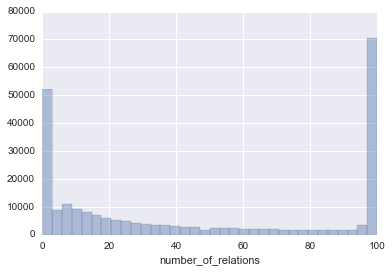

In [8]:
import seaborn as sns
sns.set(color_codes=True)
sns.distplot(fulldf["number_of_relations"],kde=False);

The previous assumption sounds even more legitimate when we take a look at the scatter plot number of neighbors (item bought by same users) plotted with respect to the salesRank . Indeed, the less popular items(salesRank>200000) have very few neighbors which makes sense because few people buy them, meaning they are overall less recommended. Within the giant component(salesRank<200000), the number of nieghbors is homogeneously distributed . 


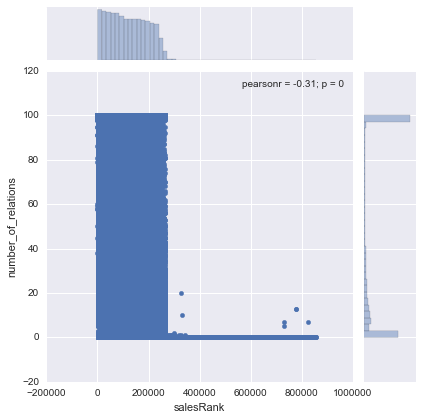

In [9]:
only2cols=fulldf[["salesRank","number_of_relations"]]
sns.jointplot(x="salesRank", y="number_of_relations", data=only2cols)

Now, Let's use the "related" column as a pivot to create a new dataframe. It is actually a set of related items exclusively within our dataset

In [10]:
fullindex=fulldf.index
def pairs_row(row):
    return [[row,r] for r in fulldf.ix[row]["related"]]
pairlist=fullindex.map(pairs_row)
pairlist=[i for ls in pairlist for i in ls]
final_pairlist=[]
for p in pairlist:
    if( p[1] in fullindex):
        final_pairlist.append(p)
final_pairlist=np.matrix(final_pairlist)
big_relationships_df=pd.DataFrame(final_pairlist)
big_relationships_df.columns=["Item1","Item2"]

In [11]:
big_relationships_df.head()

,Item1,Item2
0,B00DR0PDNE,B001FWYGJS
1,B00DR0PDNE,B00DVFLJKQ
2,B00DR0PDNE,B009X3UW2G
3,B00DR0PDNE,B00DVFLJDS
4,B00DR0PDNE,B00C2P61FO


In [12]:
litteral_to_ordinal_index=dict({})
for idx in range(len(fullindex)):
    litteral_to_ordinal_index[fullindex[idx]]=idx
def toOrdinal(idx):
    return litteral_to_ordinal_index[idx]
s1=pd.Series(big_relationships_df["Item1"].map(toOrdinal))
s2=pd.Series(big_relationships_df["Item2"].map(toOrdinal))
ordinalsDF=pd.concat([s1,s2],axis=1)
ordinalsDF.columns=["Item1","Item2"]

Now Let's have a look at the adjacency matrix i.e the pairs of items within our dataset that were sold together. Without any surprise, the matrix is much denser within a single catgory (matrix divided into squares, the boundaries of which represent the index range of a category). But what interests us the most here is the inter-category joint sales, and we can see they are not that rare, especially between CDs and books (second and third part of the index range). Indeed this part of the matrix is not very sparse in comparison with the electronics-CDs part(first and second). So a considerable part of the users who buy their books on Amazon also buy their CDs there.

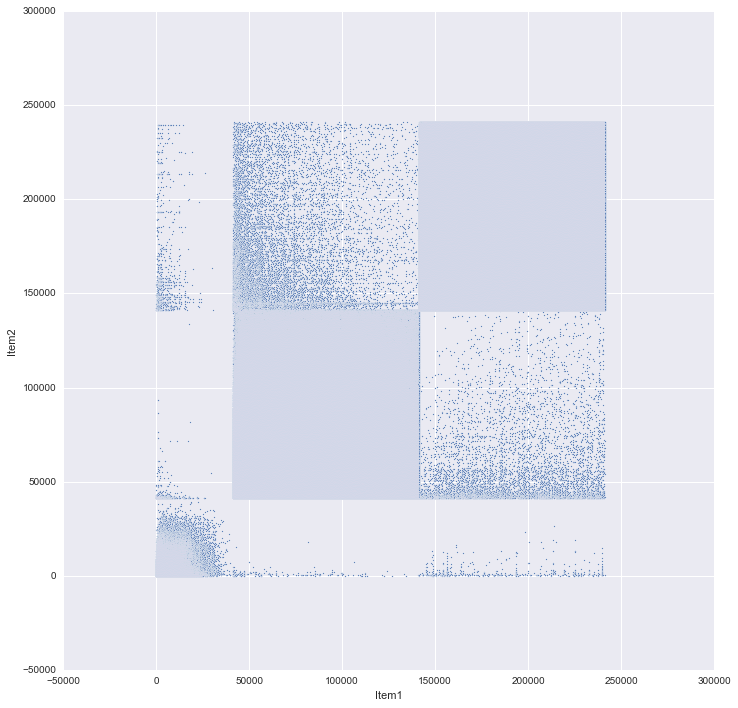

In [14]:
sns.pairplot(ordinalsDF,x_vars="Item1",y_vars="Item2",size=10,plot_kws={"s": 2})

Here, we want to do the same pairings but only for a dataset that contains the top 30 of each category. The purpose behind
this is to create a graph to visualize the realtionships between them and verify our previous statement(joint sales being much more frequent within the same category)

In [233]:
elite_=pd.concat([top_100000_elec.head(30),top_100000_CD.head(30),top_100000_books.head(30)])
cats=["Electronics"]*30 ,["CDs"]*30 ,["Books"]*30
cats=[s for l in cats for s in l]
elite_["category"]=cats
elite_["related"]=elite_["related"].map(alsobought)
eliteindex=elite_.index
elitepairlist=eliteindex.map(pairs_row)
elitepairlist=[i for ls in elitepairlist for i in ls]
final_elite_pairlist=[]
for p in elitepairlist:
    if( p[1] in eliteindex):
        final_elite_pairlist.append(p)
final_elite_pairlist=np.matrix(final_elite_pairlist)
elite_relationships_df=pd.DataFrame(final_elite_pairlist)
elite_relationships_df.columns=["Item1","Item2"]

In [234]:
elite_ordinal_indexes=dict({})
index_to_title=dict({})
index_to_cat=dict({})

iteration_=0
for i in np.arange(len(eliteindex)):
    elite_ordinal_indexes[eliteindex[i]]=iteration_
    iteration_=iteration_+1
for idx in eliteindex:
    index_to_title[idx]=elite_.ix[idx]["title"]
    index_to_cat[idx]=elite_.ix[idx]["category"]

def ordinalElite(idx):
    return elite_ordinal_indexes[idx]
elite_relationships_df["Item1"]=elite_relationships_df["Item1"].map(ordinalElite)
elite_relationships_df["Item2"]=elite_relationships_df["Item2"].map(ordinalElite)

nodes=[dict({"name":index_to_title[idx],"category":index_to_cat[idx]}) for idx in eliteindex]
edges=[dict({"source":int(row[0]),"target":int(row[1])}) for row in elite_relationships_df.values ]

In [243]:
elite_relationships_df.head()

,Item1,Item2
0,0,1
1,0,16
2,0,20
3,2,6
4,2,20


In [238]:
json.dump(nodes,open("Downloads/nodesMulticat.json","w"),separators=(',\n',":"))
json.dump(edges,open("Downloads/edgesMulticat.json","w"),separators=(',\n',":"))

The resulting graph can be found in the file "firstGraph.html". A red dot represents a CD, a yellow one an electronic item and a green one a book,
we see that in this part of the data, the items are almost exclusively related to items in their category.